In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install scikit-learn==0.21.3
!pip install fastai==0.7
from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics


  Using cached torchtext-0.5.0-py3-none-any.whl (73 kB)
  Using cached torch-0.1.2.post2.tar.gz (128 kB)


  ERROR: Command errored out with exit status 1:
   command: /home/ricco/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-dcfw89xr/torch/setup.py'"'"'; __file__='"'"'/tmp/pip-install-dcfw89xr/torch/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-_hx9eda4
       cwd: /tmp/pip-install-dcfw89xr/torch/
  Complete output (30 lines):
  running bdist_wheel
  running build
  running build_deps
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "/tmp/pip-install-dcfw89xr/torch/setup.py", line 265, in <module>
      description="Tensors and Dynamic neural networks in Python with strong GPU acceleration",
    File "/home/ricco/anaconda3/lib/python3.7/site-packages/setuptools/__init__.py", line 144, in setup
      return distutils.core.setup(**attrs)
    File 

In [82]:
df_raw= pd.read_feather ('tmp/bulldozers-raw')
df_trn, y_trn, nas= proc_df(df_raw, 'SalePrice')

In [83]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [84]:
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]

Basic data structures

In [85]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [86]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    # This just does one decision; we'll make it recursive later
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
            
    # We'll write this later!
    def find_better_split(self, var_idx):
        x, y= self.x.values[self.idxs, var_idx], self.y[self.idxs]

        for i in range(1, self.n-1):
            lhs= x<=x[i] #array of booleans
            rhs= x>x[i]
            if rhs.sum()==0: continue
            lhs_std= y[lhs].std()
            rhs_std= y[rhs].std()
            curr_score= lhs_std*lhs.sum() + rhs_std*rhs.sum()
            if curr_score<self.score:
                self.var_idx, self.score, self.split= var_idx, curr_score, x[i]

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

In [87]:
ens= TreeEnsemble(x_sub, y_train, 1, 1000)
tree= ens.trees[0]
x_samp, y_samp= tree.x, tree.y
x_samp.columns

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

In [88]:
tree

n: 1000; val:10.079014121552744; score:658.5510186055949; split:1974.0; var:YearMade

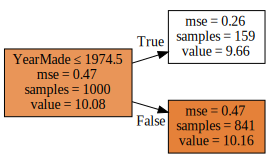

In [89]:
m= RandomForestRegressor(n_estimators=1, max_depth=1, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

In [90]:
%timeit find_better_split(tree, 1)
tree

1.65 ms ± 30 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


n: 1000; val:10.079014121552744; score:658.5510186055949; split:1974.0; var:YearMade

In [91]:
find_better_split(tree, 0); tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

Speeding things up

In [92]:
tree= TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]

In [93]:


def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

def find_better_split(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
    
    sort_idx = np.argsort(x)
    sort_y,sort_x = y[sort_idx], x[sort_idx]
    rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
    lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

    for i in range(0,self.n-self.min_leaf):
        xi,yi = sort_x[i],sort_y[i]
        lhs_cnt += 1; rhs_cnt -= 1
        lhs_sum += yi; rhs_sum -= yi
        lhs_sum2 += yi**2; rhs_sum2 -= yi**2
        if i<self.min_leaf-1 or xi==sort_x[i+1]:
            continue
            
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,xi



In [94]:
%timeit find_better_split(tree, 1)
tree

1.64 ms ± 25.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


n: 1000; val:10.079014121552744; score:658.5510186055949; split:1974.0; var:YearMade

In [95]:
find_better_split(tree,0); tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

In [96]:
DecisionTree.find_better_split= find_better_split

In [97]:
tree= TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

Full single tree

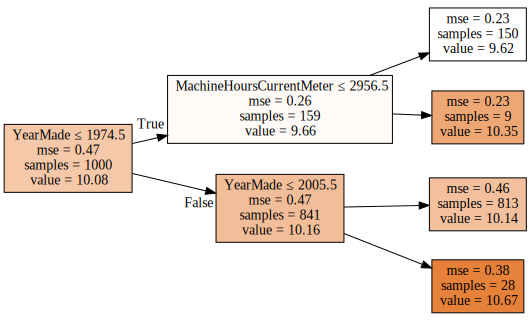

In [99]:
m= RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

In [100]:
def find_varsplit(self):
    for i in range(self.c): self.find_better_split(i)
    if self.is_leaf: return
    x=self.split_col
    lhs= np.nonzero(x<=self.split)[0]
    rhs= np.nonzero(x>self.split)[0]
    self.lhs= DecisionTree(self.x, self.y, self.idxs[lhs])
    self.rhs= DecisionTree(self.x, self.y, self.idxs[rhs])

In [101]:
DecisionTree.find_varsplit= find_varsplit

In [102]:
tree= TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

In [103]:
tree.lhs

n: 159; val:9.660892662981706; score:76.82696888346362; split:2800.0; var:MachineHoursCurrentMeter

In [104]:
tree.rhs

n: 841; val:10.158064432982941; score:571.4803525045031; split:2005.0; var:YearMade

In [105]:
tree.lhs.lhs

n: 150; val:9.619280538108496; score:71.15906938383463; split:1000.0; var:YearMade

In [107]:
tree.lhs.rhs

n: 9; val:10.354428077535193